# Project 3: Web APIs & Classification

### *Reddit: Relationship and Break Up Thread Classifier*

### 1. The Problem:
Can reddit posts from Relationship and Break Up subbreddit threads be classified into their respective thread based on their title?


### 2. Gather Data: Webscraping

**Importing libraries**

In [1]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import requests
import time
import pandas as pd

**Importing & Inspecting URLs**

In [3]:
url_rel = 'https://www.reddit.com/r/relationships.json'

In [4]:
url_bre = 'https://www.reddit.com/r/BreakUps.json'

In [5]:
headers = {'User-agent': 'Miabot'}

In [6]:
res_rel = requests.get(url_rel, headers=headers)

In [7]:
res_rel.status_code

200

In [8]:
res_bre = requests.get(url_bre, headers=headers)

In [9]:
res_bre.status_code

200

In [10]:
rel_json = res_rel.json()

In [11]:
sorted(rel_json.keys())

['data', 'kind']

In [12]:
sorted(rel_json['data'].keys())

['after', 'before', 'children', 'dist', 'modhash']

After is the ID of the last post in the list.  ID for the post is what the anchor needs to be when hit the API.  Children are the posts on the reddit page. 

In [13]:
len(rel_json['data']['children'])

25

In [14]:
bre_json = res_bre.json()

In [15]:
len(bre_json['data']['children'])

27

In [16]:
bre_json['data']['after']

't3_b9amcn'

In [17]:
param = {'after': 't3_b91y9a'}

#### Webscraping

I originally scraped 500 posts from each thread.  When I finished my model, I found there was a large gap between the train and test score.  I increased the scrape to approx. 1000 posts per thread.  This improved the score variance between the trian and test.

In [18]:
#from Riley youtube
posts = []
after = None
for _ in range(40):
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url_rel = 'https://www.reddit.com/r/relationships.json'
    res_rel = requests.get(url_rel, params=params, headers=headers)
    rel_json = res_rel.json()
    posts.extend(rel_json['data']['children'])
    after = rel_json['data']['after']
    time.sleep(1)

In [21]:
titles = []
for post in posts:
    titles.append(post['data']['title'])

In [23]:
#from Riley youtube
posts2 = []
after = None
for _ in range(40):
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url_bre = 'https://www.reddit.com/r/BreakUps.json'
    res_bre = requests.get(url_bre, params=params, headers=headers)
    bre_json = res_bre.json()
    posts2.extend(bre_json['data']['children'])
    after = bre_json['data']['after']
    time.sleep(1)

In [25]:
titles2 = []
for post2 in posts2:
    titles2.append(post2['data']['title'])

### 3. Explore Data: 

In exploring the scraped data I discovered that there were a lot of posts where the text was removed.  However, all the posts in both threads had very descriptive titles.  I decided to create my model using the titles from these threads.  The format of the titles seemed to vary between the two threads, so I thought this would increase the predictive ability of the model.

In [36]:
df['subreddit'].value_counts(normalize=True)

0    0.502006
1    0.497994
Name: subreddit, dtype: float64

The classification models will not be biased to predict one class exclusively because the value counts are roughly even for both the positive class (r/breakups) and the negative class (r/relationships).

In [24]:
posts2[2]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'BreakUps',
  'selftext': '  \n\nWhen you pour yourself into a relationship, into someone, when you shower them with love and respect and support, when you give give give and receive only 1% back and don’t even mind, when you don’t listen to what anyone says because you KNOW what you feel and you don’t want to lose it, when you ignore all the red flags excusing them and finding reasons behind them…..\n\nYou lose the one you love.\n\nThey’ll take you for granted, they’ll lazily adjust to the presence of the love you give, they’ll slowly but surely stop working for it.\n\nAnd then they’ll leave.\n\nBecause at some point you’ll notice that they’re not involved anymore, they don’t give anymore, they just don’t SEE you anymore. And you’ll ask them why. And they won’t know why, they won’t even know why you’re asking all of a sudden, why are you so needy, so clingy, why? And you’ll blindly give more and more, naively hoping that

#### Combining Both Scrapes into DataFrame

In [27]:
reddit = pd.DataFrame(titles2, columns=['title'])

In [28]:
reddit['subreddit'] = 0

In [29]:
reddit.head()

,title,subreddit
0,I've created a Discord for group chats.,0
1,Anyone else want anon group therapy to get ove...,0
2,They always come back.,0
3,They’re not worth your time or your worry,0
4,Seeing them on r/Breakups,0


In [30]:
reddit_bre = pd.DataFrame(titles, columns=['title'])

In [31]:
reddit_bre['subreddit'] = 1

In [32]:
reddit_bre.head()

,title,subreddit
0,"My (27m) wife (25f, together 8 years, married ...",1
1,Bf is commanding on things I shouldn't do.,1
2,I [26F] don’t know how to handle my disrespect...,1
3,Am I in the wrong for saying my boyfriend need...,1
4,"My (24F) parents (40F, 45M) expect my husband ...",1


In [33]:
df = pd.concat(objs=(reddit, reddit_bre), axis=0)

In [34]:
df.head()

,title,subreddit
0,I've created a Discord for group chats.,0
1,Anyone else want anon group therapy to get ove...,0
2,They always come back.,0
3,They’re not worth your time or your worry,0
4,Seeing them on r/Breakups,0


In [35]:
df.tail()

,title,subreddit
988,My (26f) SO (31m) acting strangly about runnin...,1
989,Sister(25) keeps going back to abusive boyfrie...,1
990,17f feels trapped in relationship with 20m,1
991,How do I [21 M] support and help my girlfriend...,1
992,Gf wants to go “on tour” with her escort frien...,1


### 4. Model with Data: 

### *Hashing Vectorizer + Multinomial Naive Bayes Model*

I decided to start with a hashing vectorizer because although it is not as precise as a count vectorizer, it is fast with large amounts of data.

In [37]:
X = df[['title']]
y = df['subreddit']

In [38]:
print(len(X))
print(len(y))

1994
1994


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [40]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(stop_words='english')

In [41]:
X_train_hv = pd.DataFrame(hv.fit_transform(X_train['title']).todense())

In [42]:
X_test_hv = pd.DataFrame(hv.transform(X_test['title']).todense())

In [43]:
from sklearn.naive_bayes import MultinomialNB

In [44]:
nb = MultinomialNB()

In [45]:
model = nb.fit(X_train_hv, y_train)

In [46]:
model.score(X_train_hv, y_train)

0.5190635451505017

The hashing vectorizer got a very low score on the train, so I decided to move straight to the count vectorizer.  

### *Count Vectorizer + Multinomial Naive Bayes Model*

I chose to try the count vectorizer because it is more precise.  Additionally, I will be able to determine which words were used in the model.  I decided to remove stopwords because they will be common in both subreddit scrapes, and will not improve the predictability of the model.

In [47]:
from nltk.corpus import stopwords

In [106]:
mystopwords = stopwords.words('english')

In [49]:
mystopwords.extend(['ex', 'don']) #see below for explanation of why these words were removed

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words=mystopwords, ngram_range=(1,1))

In [108]:
X_train_cv = pd.DataFrame(cv.fit_transform(X_train['title']).todense(), columns=cv.get_feature_names())

In [109]:
X_test_cv = pd.DataFrame(cv.transform(X_test['title']).todense(), columns=cv.get_feature_names())

In [89]:
nb = MultinomialNB()

In [90]:
model = nb.fit(X_train_cv, y_train)

In [91]:
model.score(X_train_cv, y_train)

0.939799331103679

In [92]:
model.score(X_test_cv, y_test)

0.9098196392785571

The count vectorizer with a Multinomial naive bayes model performed well on both the train and test data.  I decided to save this webscrape because it provided me with strong results.  I tested on several different days with new webscrapes and all models performed about the same.  

In [93]:
postcsv = pd.DataFrame(posts)

In [94]:
postcsv.to_csv('posts.csv', index=False)

In [95]:
posts2csv = pd.DataFrame(posts2)

In [96]:
posts2csv.to_csv('posts2.csv', index=False)

The count vectorizer is not a black box like the hashing vectorizer.  The count vectorizer keeps count of the frequency distribution of the tokens.  I plotted this frequency below to see what words were predictive in each model, and to see if there was any overlap between the two models.

### r/Relationships Frequency Distribution of Top 50 Tokens

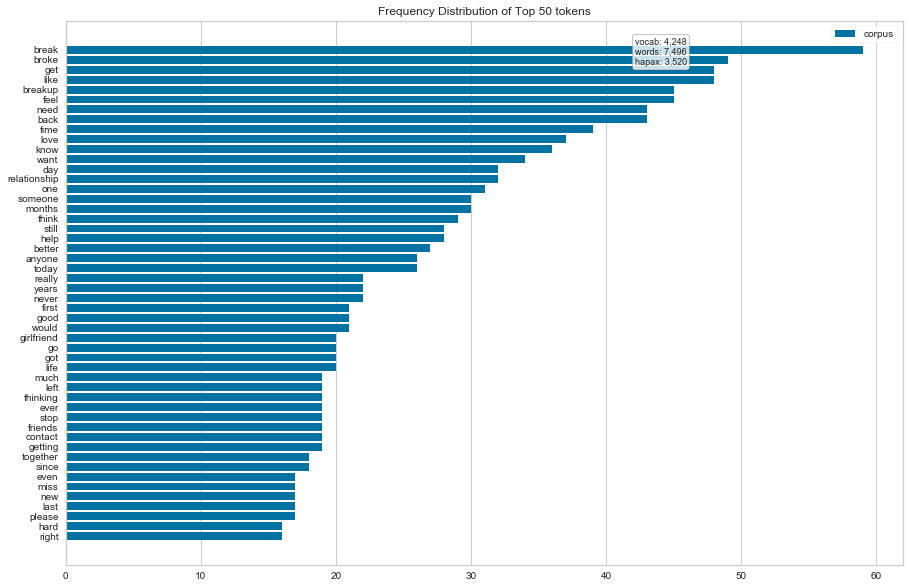

In [85]:
#https://www.scikit-yb.org/en/latest/api/text/freqdist.html
import matplotlib.pyplot as plt
vectorizer = CountVectorizer(stop_words=mystopwords, ngram_range=(1,2))
docs       = vectorizer.fit_transform(reddit['title'])
features   = vectorizer.get_feature_names()

plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

### r/BreakUps Frequency Distribution of Top 50 Tokens

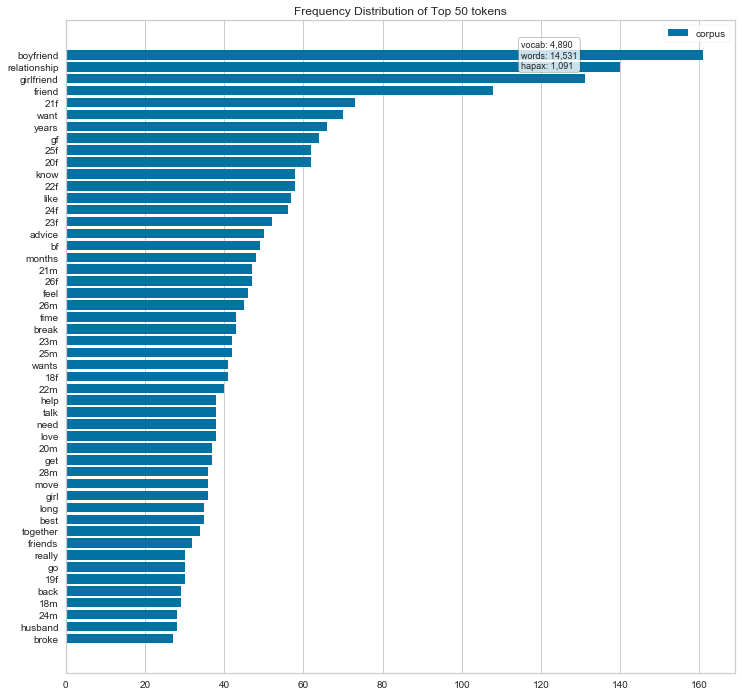

In [84]:
vectorizer = CountVectorizer(stop_words=mystopwords, ngram_range=(1,2))
docs       = vectorizer.fit_transform(reddit_bre['title'])
features   = vectorizer.get_feature_names()

plt.figure(figsize=(12,12))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

The two words that had very high token frequency in both threads were: 'ex' and 'don.'  I removed these words from my model because I thought they may be misclassifying the posts due to their high frequency in both threads.  My model improved 1% with the words removed.

Plotting the frequency distribution of the tokens allowed me to see that the format of the titles has an impact on the model.  The r/BreakUps thread uses mentions age and sex of the people being discussed.  For example, a 24 year old male would be called a 24m.  This is very frequent in the r/BreakUps thread, and thus is very predictive in the model.

### *Count Vectorizer + Logistic Regression*

In [114]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [115]:
lr.fit(X_train_cv, y_train)

C:\Users\mia.martin\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [116]:
lr.score(X_train_cv, y_train)

0.9705685618729097

In [117]:
lr.score(X_test_cv, y_test)

0.9158316633266533

The logistic regression did a better job of predicting the subreddit thread than the naive bayes model, so I will use the logistic regression in my model.

### *Count Vectorizer + Ridge Regression*

I tried a ridge regression because some of the words in the model were predictive of both threads.  

In [110]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
ridge = RidgeCV()
ridge.fit(X_train_cv, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [111]:
ridge.score(X_train_cv, y_train)

0.9318935795436548

In [112]:
ridge.score(X_test_cv, y_test)

0.6804981865255555

The ridge regression will penalize these features that are not improving the predictability of the model.  However, the ridge regression did not perform well on the test data, so I decided not to use the ridge in my final model.

### 4. Evaluate Model: 

The **hashing vectorizer** with a **Multinomial Naive Bayes model** performed the worst on the train data with 52% accuracy score on training data.  The hashing vectorizer has the benefit of being fast, but it is less precise.  

The **count vectorizer** with a **Multinomial Naive Bayes model** performed much better with 94% on train data and 91% on test data.  

The **count vectorizer** with a **Logistic Regression model** performed the best with 97% accuracy on training data and 92% on test data.  The logistic model with a count vectorizer performed the best because:
1. The count vectorizer is more precise than the hashing vectorizer.
2. The logistic model was better fit to this classification problem than the Naive Bayes model.

### 5. Answer Problem: 

Title can be used to predict classification of subreddit thread between r/Relationships and r/BreakUps with 92% accuracy, as shown in the logistic regression above using a count vectorizer.  

The formatting of the titles has a large impact on the predictibility of the model.  Both threads discuss both relationships and break ups.  However, the r/BreakUps thread uses age and sex as identifiers in the title.  The r/Relationships thread includes more descriptive language in the title.

If I had more time and more data I would like to dive deeper into the predictive features in subreddit threads.  I think adding in the text of the thread would be a great feature to explore because it allows for more data (text is longer than title, therefore more content).  The data I scraped had too many removed posts with text removed, so I could not use text in this model.  I plan to scrape the data again at a later point to see if I can find more data without removed text.  